# Reproducing Adam CDA Study (2018) Exp1 - L vs R

### Notes

In [1]:
import numpy as np
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

from scipy.io import loadmat

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Adam-2018/')
from events import convert_triggers, get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

# --------------------------
# Fuck-up with events when loading in Python. I don't know why... NEED TO CONVERT.
triggers['1'] = [31, 41]
triggers['3'] = [33, 43]
triggers['6'] = [36, 46]

triggers['left'] = [31, 33, 36]
triggers['right'] = [41, 43, 46]

triggers['good'] = [81,82,83,84,85,86]
triggers['bad'] = [80]

triggers['acc_0'] = [80]
triggers['acc_1'] = [81]
triggers['acc_2'] = [82]
triggers['acc_3'] = [83]
triggers['acc_4'] = [84]
triggers['acc_5'] = [85]
triggers['acc_6'] = [86]
    
# Labels
conds = ['1', '3', '6']
sides = ['left', 'right']
perfs = ['good', 'bad'] # Here it is slightly different! (because of granular accuracies!)
accs =  ['acc_0', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_5', 'acc_6']

# CDA Channels
chan_right = ['O2', 'OR', 'P4', 'PO4', 'T6']
chan_left =  ['O1', 'OL', 'P3', 'PO3', 'T5']

# Channels
chanLabels = {'EEG 000':'PO3', 'EEG 001':'PO4', 'EEG 002':'F3', 'EEG 003':'F4', 'EEG 004':'C3', 'EEG 005':'C4', 'EEG 006':'P3', 'EEG 007':'P4', 'EEG 008':'O1', 'EEG 009':'O2', 'EEG 010':'OL', 'EEG 011':'OR', 'EEG 012':'T3', 'EEG 013':'T4', 'EEG 014':'T5', 'EEG 015':'T6', 'EEG 016':'POz', 'EEG 017':'Cz', 'EEG 018':'Fz', 'EEG 019':'Pz', 'EEG 020':'VEOG', 'EEG 021':'HEOG'}

# Epoch Information
epoch_length = 1.5  #1.65
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable!
cda_dict = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, accs)#perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Adams 2018\\Experiment 1\\Raw EEG Files (.rdf)\\YR EEGLab Files\\'
directory_path = '/Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/'

eegfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(directory_path)
    for f in files if f.endswith('.set')]

#filepath = directory_path + '1_DWR_Bilateral.set'
for filepath in eegfiles:
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_eeglab(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    preproc = raw

    # Rename channels
    preproc.rename_channels(chanLabels);

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)

    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    #=====================================
    # Convert Events ID -- Not sure why MNE-Python switches them...
    #=====================================
    new_triggers = copy.deepcopy(triggers)
    new_triggers = convert_triggers(events, conds, sides, perfs, accs, new_triggers)

    specific_events = get_specific_events(events[0], conds, sides, perfs, accs, new_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
    
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    #report = fill_report(report, filename, specific_events)
    #report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, accs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['3']['left']['acc_1'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: 10_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/10_DWR_Bilateral.fdt
Reading 0 ... 1847167  =      0.000 ...  7388.668 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125'

Loading data for 5 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 p

0 projection items activated
Loading data for 19 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
67 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 67 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_1 -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 426 original time points ...
0 bad epochs dropped
-

---------- 1-right-acc_2 -------------
---------- 1-right-acc_3 -------------
---------- 1-right-acc_4 -------------
---------- 1-right-acc_5 -------------
---------- 1-right-acc_6 -------------
---------- 3-left-acc_0 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 ------------

Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
131 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 131 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
132 matching event

    Range : 0 ... 1719295 =      0.000 ...  6877.180 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1719296
    Range : 0 ... 1719295 =      0.000 ...  6877.180 secs
Ready.
Added the following bipolar channels:
OR-OL
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1719296
    Range : 0 ... 1719295 =      0.000 ...  6877.180 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1719296
    Range : 0 ... 1719295 =      0.000 ...  6877.180 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1719296
    Range : 0 ... 1719295 =      0.000 ...  6877.180 secs
Ready.
Added the following bipolar channels:
T6-T5
New t

0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Processing: 15_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/15_DWR_Bilateral.fdt
Reading 0 ... 1518975  =      0.000 ...  6075.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotati

Loading data for 5 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0

Loading data for 7 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_2 -------------
Not setting metadata
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 29 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_3 -------------
Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 40 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 p

---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 60 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
---------- 3-left-acc_6 -------------
---------- 3-right-acc_0 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying b

0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 426 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading 

Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1860352
    Range : 0 ... 1860351 =      0.000 ...  7441.404 secs
Ready.
Added the following bipolar channels:
OR-OL
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1860352
    Range : 0 ... 1860351 =      0.000 ...  7441.404 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1860352
    Range : 0 ... 1860351 =      0.000 ...  7441.404 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1860352
    Range : 0 ... 1860351 =      0.000 ...  7441.404 secs
Ready.
Added the following bipolar channels:
T6-T5
New trigger(s) for 1: [58, 61]
New trigger(s) for 3: [59, 62]
N

Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Processing: 20_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/20_DWR_Bilateral.fdt
Reading 0 ... 2015615  =      0.000 ...  8062.460 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 d

Loading data for 13 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 24 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
44 matching events found
Applyi

0 projection items activated
Loading data for 9 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 35 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 426 original time points ...
0 bad epochs dropped
---

0 projection items activated
Loading data for 115 events and 426 original time points ...
0 bad epochs dropped
---------- 1-right-acc_2 -------------
---------- 1-right-acc_3 -------------
---------- 1-right-acc_4 -------------
---------- 1-right-acc_5 -------------
---------- 1-right-acc_6 -------------
---------- 3-left-acc_0 -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
52 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Load

A total of 750 events were added and 0 were skipped.
====================== EPOCHING ======================
tmin:-0.2, tmax:1.5, baseline=(-0.2, 0)
---------- 1-left-acc_0 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 115 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)

Creating RawArray with float64 data, n_channels=1, n_times=1735424
    Range : 0 ... 1735423 =      0.000 ...  6941.692 secs
Ready.
Added the following bipolar channels:
OR-OL
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1735424
    Range : 0 ... 1735423 =      0.000 ...  6941.692 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1735424
    Range : 0 ... 1735423 =      0.000 ...  6941.692 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1735424
    Range : 0 ... 1735423 =      0.000 ...  6941.692 secs
Ready.
Added the following bipolar channels:
T6-T5
New trigger(s) for 1: [61, 64]
New trigger(s) for 3: [62, 65]
New trigger(s) for 6: [63, 66]
New trigger(s) for left: [61, 62, 63]
New trigger(s) for right: [6

Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/25_DWR_Bilateral.fdt
Reading 0 ... 2005375  =      0.000 ...  8021.500 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

Used Annotations descriptions: ['101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', 

0 bad epochs dropped
---------- 6-left-acc_6 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 42

0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_1 -------------
Not setting metadata
Not setting metadata
32 matchi

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 95 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -------------
---------- 3-left-acc_5 -------------
----

A total of 541 events were added and 0 were skipped.
====================== EPOCHING ======================
tmin:-0.2, tmax:1.5, baseline=(-0.2, 0)
---------- 1-left-acc_0 -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 78 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1834752
    Range : 0 ... 1834751 =      0.000 ...  7339.004 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1834752
    Range : 0 ... 1834751 =      0.000 ...  7339.004 secs
Ready.
Added the following bipolar channels:
OR-OL
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1834752
    Range : 0 ... 1834751 =      0.000 ...  7339.004 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1834752
    Range : 0 ... 1834751 =      0.000 ...  7339.004 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1834752
  

0 projection items activated
Loading data for 15 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 3_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/3_DWR_Bilateral.fdt
Reading 0 ... 1884287  =      0.000 ...  7537.148 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting metadata
Not setting metadata
44 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 44 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_4 -------------
Not setting metadata
Not setting metadata
49 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 49 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_5 -------------
Not setting metadata
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 29 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 ---

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_2 -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_3 -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_4 -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metada

Loading data for 2 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_1 -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 36 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -----

Not setting metadata
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 426 original time points ...
0 bad epochs dropped
---------- 1-right-acc_2 -------------
---------- 1-right-acc_3 -------------
---------- 1-right-acc_4 -------------
---------- 1-right-acc_5 -------------
---------- 1-right-acc_6 -------------
---------- 3-left-acc_0 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
25 matching eve

    Range : 0 ... 1973119 =      0.000 ...  7892.476 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1973120
    Range : 0 ... 1973119 =      0.000 ...  7892.476 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1973120
    Range : 0 ... 1973119 =      0.000 ...  7892.476 secs
Ready.
Added the following bipolar channels:
T6-T5
New trigger(s) for 1: [62, 65]
New trigger(s) for 3: [63, 66]
New trigger(s) for 6: [64, 67]
New trigger(s) for left: [62, 63, 64]
New trigger(s) for right: [65, 66, 67]
New trigger(s) for good: [69, 70, 71, 72, 73, 74]
New trigger(s) for bad: [68]
New trigger(s) for acc_0: [68]
New trigger(s) for acc_1: [69]
New trigger(s) for acc_2: [70]
New trigger(s) for acc_3: [71]
New trigger(s) for acc_4: [72]
New trigger(s) for acc_5: [73]
New trigger(

---------- 6-right-acc_6 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 4_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/4_DWR_Bilateral.fdt
Reading 0 ... 1949311  =      0.000 ...  7797.244 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandw

12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_5 -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_6 -------------
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 25 events and 426 original time points ...
0 bad epochs dropped
---------- 6-rig

0 bad epochs dropped
---------- 3-right-acc_2 -------------
Not setting metadata
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 36 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_3 -------------
Not setting metadata
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 426 original time points ...
0 bad epochs dropped
---------- 3-right-acc_4 -------------
---------- 3-right-acc_5 -------------
---------- 3-right-acc_6 -------------
---------- 6-left-acc_0 -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 426 original time points ...
0 bad epochs dropped
---------- 6-left-acc_1 -------------
Not setting metadata
Not setting metadata
25 matchi

Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_1 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_2 -------------
Not setting metadata
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 24 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_3 -------------
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 91 events and 426 original time points ...
0 bad epochs dropped
---------- 3-left-acc_4 -----------

Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_1 -------------
Not setting metadata
Not setting metadata
136 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 136 events and 426 original time points ...
0 bad epochs dropped
---------- 1-left-acc_2 -------------
---------- 1-left-acc_3 -------------
---------- 1-left-acc_4 -------------
---------- 1-left-acc_5 -------------
---------- 1-left-acc_6 -------------
---------- 1-right-acc_0 -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 426 original time points ...
0 bad epochs dropped
---------- 1-right-acc_1 -------------
Not setting metadata
Not setting metadata
136 matching event

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1768960
    Range : 0 ... 1768959 =      0.000 ...  7075.836 secs
Ready.
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1768960
    Range : 0 ... 1768959 =      0.000 ...  7075.836 secs
Ready.
Added the following bipolar channels:
OR-OL
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1768960
    Range : 0 ... 1768959 =      0.000 ...  7075.836 secs
Ready.
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1768960
    Range : 0 ... 1768959 =      0.000 ...  7075.836 secs
Ready.
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1768960
  

0 projection items activated
Loading data for 21 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_5 -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_6 -------------
====================== /EPOCHING ======================
Processing: 9_DWR_Bilateral.set...
Reading /Volumes/Nick - Data/CDA Datasets/Adam 2018/Experiment 1/Raw EEG Files (.rdf)/YR EEGLab Files/9_DWR_Bilateral.fdt
Reading 0 ... 2017279  =      0.000 ...  8069.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower

6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_0 -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_1 -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_2 -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 426 original time points ...
0 bad epochs dropped
---------- 6-right-acc_3 -------------
Not setting meta

,1,3,6,left,right,acc_0,acc_1,acc_2,acc_3,acc_4,...,6-right,6-right-acc_0,6-right-acc_1,6-right-acc_2,6-right-acc_3,6-right-acc_4,6-right-acc_5,6-right-acc_6,checksum,notes


In [5]:
times = cda_dict['times']
del cda_dict['times']

KeyError: 'times'

## 2. Save CDA Data

In [19]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_adam2018_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [20]:
with open("cda_adam2018_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

KeyError: 'times'

## 4. Plot CDA Data - Grand CDA Average

In [8]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for perf in accs:
        if perf != 'acc_0':
        
            for f in epochs_dict_all.keys():
                if epochs_dict_all[f][cond]['left'][perf] is not None:
                    ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
                    cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
                    
                if epochs_dict_all[f][cond]['right'][perf] is not None:
                    rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                    cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

## Final CDA figure from Adam 2018

Text(0.5, 0, '[s]')

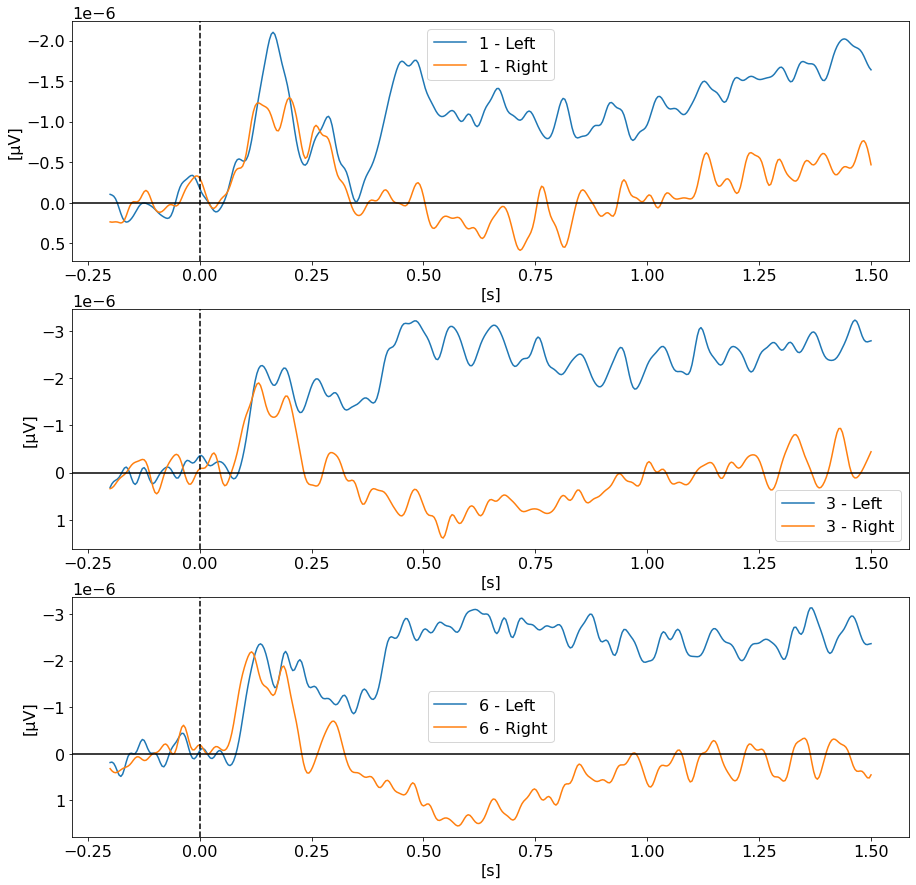

In [9]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['1']['left'].mean(0), label='1 - Left')
axs[0].plot(times, cda_all['1']['right'].mean(0), label='1 - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['3']['left'].mean(0), label='3 - Left')
axs[1].plot(times, cda_all['3']['right'].mean(0), label='3 - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #2
axs[2].plot(times, cda_all['6']['left'].mean(0), label='6 - Left')
axs[2].plot(times, cda_all['6']['right'].mean(0), label='6 - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')

Text(0.5, 0, '[s]')

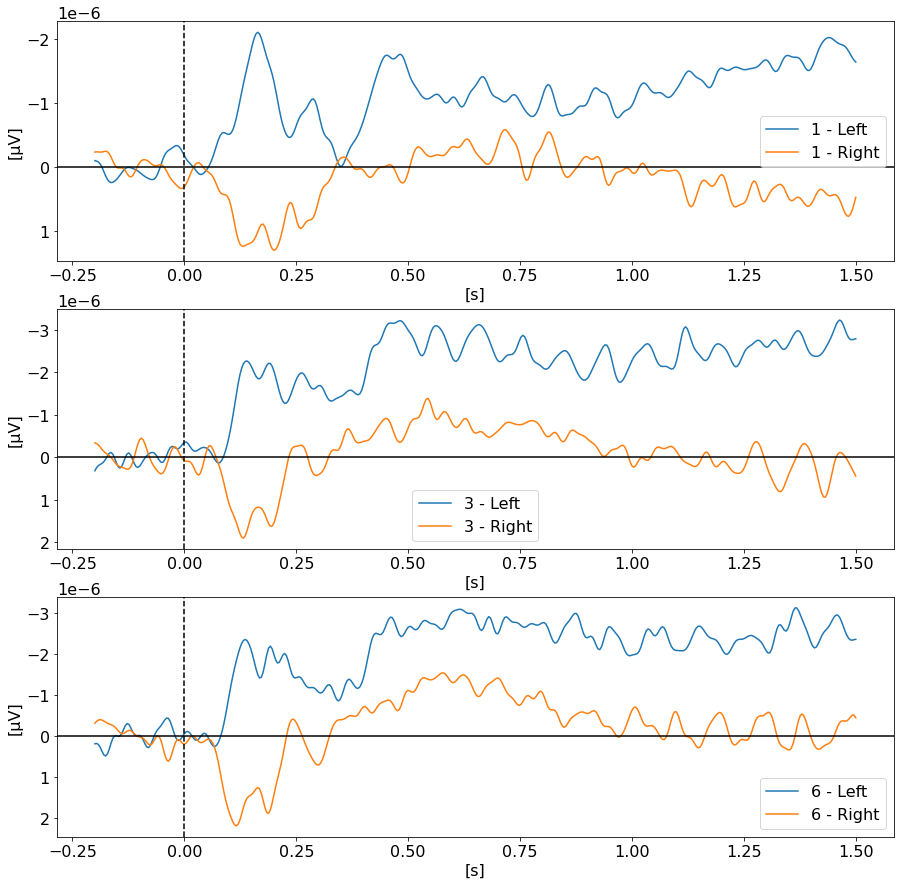

In [10]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(3, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['1']['left'].mean(0), label='1 - Left')
axs[0].plot(times, cda_all['1']['right'].mean(0) * -1, label='1 - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['3']['left'].mean(0), label='3 - Left')
axs[1].plot(times, cda_all['3']['right'].mean(0) * -1, label='3 - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #2
axs[2].plot(times, cda_all['6']['left'].mean(0), label='6 - Left')
axs[2].plot(times, cda_all['6']['right'].mean(0) * -1, label='6 - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')

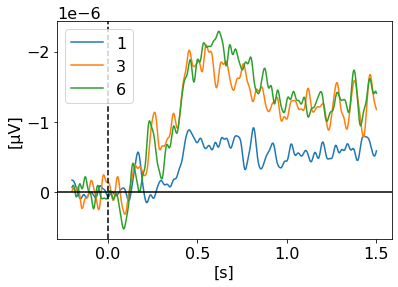

In [15]:
plt.plot(times, (cda_all['1']['left'].mean(0) + (cda_all['1']['right'].mean(0) * -1))/2, label='1')
plt.plot(times, (cda_all['3']['left'].mean(0) + (cda_all['3']['right'].mean(0) * -1))/2, label='3')
plt.plot(times, (cda_all['6']['left'].mean(0) + (cda_all['6']['right'].mean(0) * -1))/2, label='6')
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.show()